## Importing Libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Reading and Displaying Image

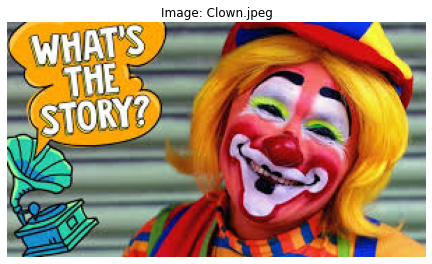

In [2]:
# read in the image using openCV cv2.imread
# openCV encodes channels as BGR, convert to RGB encoding
img_bgr = cv.imread('./imgs/clown.jpeg', cv.IMREAD_COLOR)
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

# print image
plt.figure(figsize = (7.5, 5))
plt.axis('off')
plt.title('Image: Clown.jpeg')
plt.imshow(img_rgb)
plt.show()

## Converting to Grayscale

In [3]:
# convert the image to Grayscale and print
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
print(img.shape)

(168, 300)


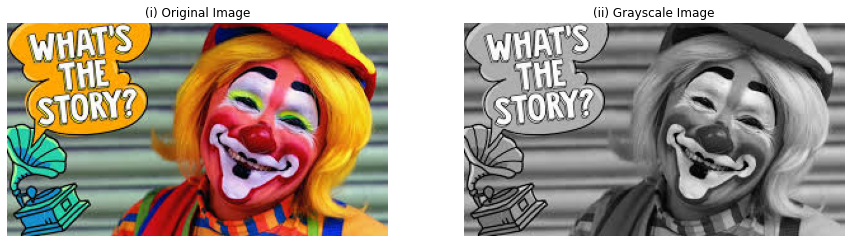

In [4]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('(i) Original Image')
plt.imshow(img_rgb, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('(ii) Grayscale Image')
plt.imshow(img, cmap = 'gray')

plt.show()

## Smoothing Image using a Gaussian Filter

In [5]:
def convolve(img, kernel):
    # get image and kernel size
    (ih, iw) = img.shape
    (kh, kw) = kernel.shape
    
    # note that kw and kh are both of the form '2k+1'
    padw = (kw - 1)//2
    padh = (kh - 1)//2
    
    # pad the image to prep for convolution
    img_pad = np.zeros((ih + 2*padh, iw + 2*padw))
    for y in np.arange(0, ih + 2*padh):
        for x in np.arange(0, iw + 2*padw):
            xx, yy = 0, 0
            
            # code for padding involves a rough implementation of 
            # the openCV cv2.BORDER_REFLECT
            if x < padw: xx = padw - x
            elif x >= padw and x < iw + padw: xx = x - padw
            else: xx = 2*iw + padw - x - 1
              
            if y < padh: yy = padh - y
            elif y >= padh and y < ih + padh: yy = y - padh
            else: yy = 2*ih + padh - y - 1 
            
            # padded image values are filled in
            img_pad[y,x] = img[yy,xx]
    
    # we fill in the output matrix
    out = np.zeros((ih, iw))
    for y in np.arange(padh, ih + padh):
        for x in np.arange(padw, iw + padw ):
            # select the region of interest (ROI)
            roi = img_pad[y - padh: y + padh + 1, x - padw: x + padw + 1]
            # carry out the convolution
            conv = (roi * kernel).sum()
            out[y - padh, x - padw] = conv 
    
    return out

In [6]:
# code to define a gaussian kernel 
def gaussian_kernel(size, sigma):
    g = np.ones((size, size))
    k = size//2
    norm = 1/(2 * np.pi * (sigma**2))
    
    
    for i in np.arange(0, size):
        for j in np.arange(0, size):
            g[i, j] = np.exp(-1*((i - k)**2 + (j - k)**2)/(2*(sigma**2)))
            g[i, j] = norm * g[i, j] 
    
    return g

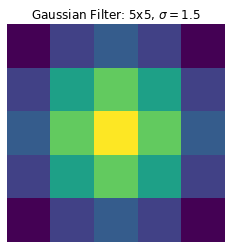

In [7]:
# here we get the gaussian kernel we will use for blurring
gauss1 = gaussian_kernel(5, 1.5)
plt.axis('off')
plt.title(r'Gaussian Filter: 5x5, $\sigma = 1.5$')
plt.imshow(gauss1, cmap = 'viridis')
plt.show()

(168, 300)


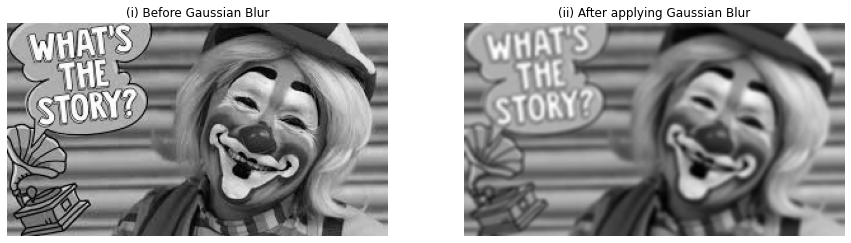

In [8]:
# we print the blurred matrix
blur1 = np.round(convolve(img, gauss1))
print(blur1.shape)

fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('(i) Before Gaussian Blur')
plt.imshow(img, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('(ii) After applying Gaussian Blur')
plt.imshow(blur1, cmap = 'gray')
plt.show()

## Calculating the Gradients 

In [9]:
# sobel filters for gradient calculation
sobelX = np.array([[-1, 0, +1], [-2, 0, +2], [-1, 0, +1]], dtype = np.float32)
sobelY = np.array([[+1, +2, +1], [0, 0, 0], [-1, -2, -1]], dtype = np.float32)

In [10]:
# code to get the gradient intensity and angle matrices
# done using sobel filters
def grad_matrix(img):
    gx = convolve(img, sobelX)
    gy = convolve(img, sobelY)
    
    grad = np.hypot(gx, gy)
    grad = (grad / grad.max()) * 255
    theta = np.arctan2(gy, gx)
    
    return grad, gx, gy, theta

In [11]:
# calculate the gradient matrices
grad1, gx1, gy1, theta1 = grad_matrix(blur1)
grad1 = np.round(grad1)

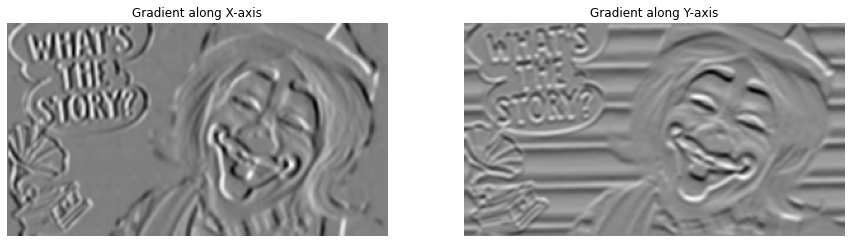

In [12]:
# print the X and Y gradients
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('Gradient along X-axis')
plt.imshow(gx1, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('Gradient along Y-axis')
plt.imshow(gy1, cmap = 'gray')
plt.show()

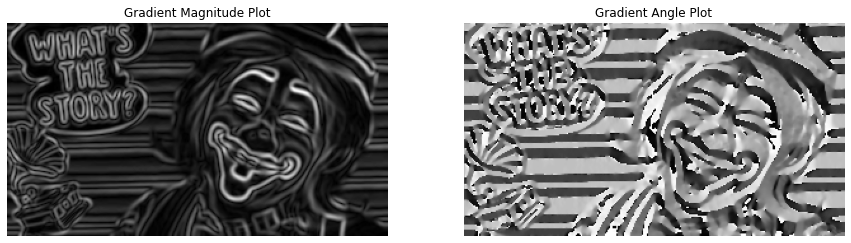

In [13]:
# we print the grad matrix now
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('Gradient Magnitude Plot')
plt.imshow(grad1, cmap = 'gray')

# we print the 'theta' matrix in raw form as well
fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('Gradient Angle Plot')
plt.imshow(theta1, cmap = 'gray')
plt.show()

In [14]:
# code to sample an image
# only pixels at a stride of 'k' are displayed
def sample(mat, k):
    (ih, iw) = mat.shape
    out = np.zeros(((ih//k), (iw//k)))
    
    for i in np.arange(0, ih):
        for j in np.arange(0, iw):
            if i%k == 0 and j%k == 0:
                out[i//k,j//k] = mat[i,j]
    
    return out

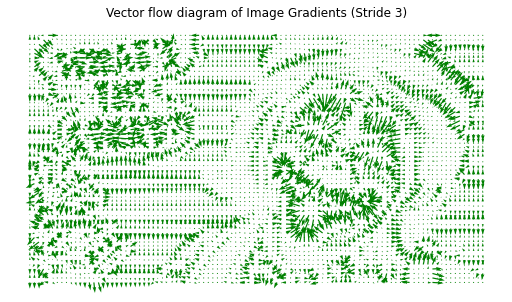

In [15]:
# we create a meshgrid
xx = np.arange(0, 300, 3)
yy = np.arange(168, 0, -3)
X, Y = np.meshgrid(xx, yy)

# we sample the gradient matrices 
# pixels are displayed with a stride of 3 so that the gradient vectors are seen clearly 
gxx1 = sample(gx1, 3)
gyy1 = sample(gy1, 3)

# plot the image
plt.figure(figsize = (125/14, 5))
plt.axis('off')
plt.title('Vector flow diagram of Image Gradients (Stride 3)')
plt.quiver(X, Y, gxx1, gyy1, color='g')
plt.show()

## Non-Maximum Suppression

In [16]:
def non_max_suppression(grad, theta):
    # for the sake of convenience we use degree instead of radian
    (ih, iw) = grad.shape
    theta = (theta * 180.)/np.pi
    
    # create a padded matrix in order to prevent IndexError exception
    grad_pad = np.ones((ih + 2, iw + 2))*255
    for y in np.arange(1, ih+1): 
        for x in np.arange(1, iw+1):
            grad_pad[y,x] = grad[y-1, x-1]
            
    out = np.copy(grad)
    
    # loop across all point in the image
    for y in np.arange(0,ih):
        for x in np.arange(0,iw):
            # rotate opposite facing gradient vectors so that they are treated equally
            if theta[y,x] < 0: theta[y,x] = theta[y,x] + 180
            
            a, b = 255, 255
            
            # based on the direction of the gradient select the neighbouring pixels
            # pixels along both directions are selected
            
            # gradient closest to 0 or 180 degree
            if 0 <= theta[y,x] < 22.5 or 157.5 <= theta[y,x] < 180:
                a = grad_pad[y+1, x+2]
                b = grad_pad[y+1, x]
                
            # gradient closest to 45 degree
            elif 22.5 <= theta[y,x] < 67.5:
                a = grad_pad[y, x+2]
                b = grad_pad[y+2, x]
                
            # gradient closest to 90 degree
            elif 67.5 <= theta[y,x] < 112.5:
                a = grad_pad[y, x+1]
                b = grad_pad[y+2, x+1]
                
            # gradient closest to 135 degree
            elif 112.5 <= theta[y,x] < 157.5:
                a = grad_pad[y, x]
                b = grad_pad[y+2, x+2]
                
            # update the values of grad[] matrix directly
            if grad_pad[y+1, x+1] >= max(a, b):
                out[y,x] = grad_pad[y+1, x+1]
            else:
                out[y,x] = 0
            
    return out

In [17]:
grad_nms1 = np.round(non_max_suppression(grad1, theta1))

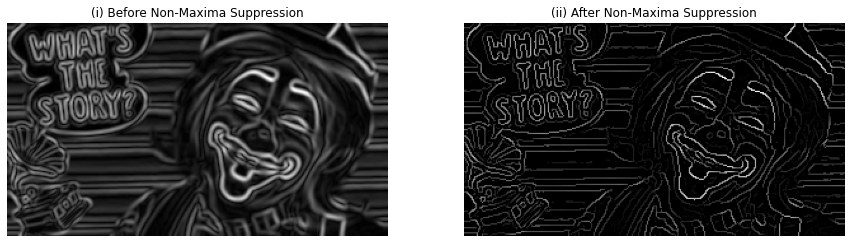

In [18]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('(i) Before Non-Maxima Suppression')
plt.imshow(grad1, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('(ii) After Non-Maxima Suppression')
plt.imshow(grad_nms1, cmap = 'gray')
plt.show()

## Thresholding

In [19]:
def median_threshold(grad_nms, grad):
    (ih, iw) = grad_nms.shape
    med = np.median(grad)
    print('Median Threshold used is:',med)
    
    canny = np.copy(grad_nms)
    for y in np.arange(ih):
        for x in np.arange(iw):
            if canny[y,x] < med: canny[y,x] = 0
            elif canny[y,x] >= med: canny[y,x] = 255
    
    return canny

In [20]:
canny1 = median_threshold(grad_nms1, grad1)

Median Threshold used is: 36.0


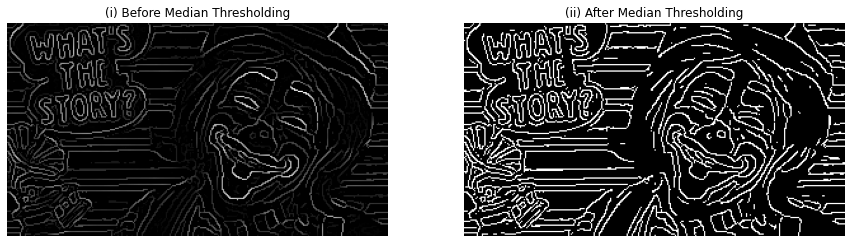

In [21]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('(i) Before Median Thresholding')
plt.imshow(grad_nms1, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('(ii) After Median Thresholding')
plt.imshow(canny1, cmap = 'gray')
plt.show()

## Using $\sigma = 3$ for Gaussian Blur

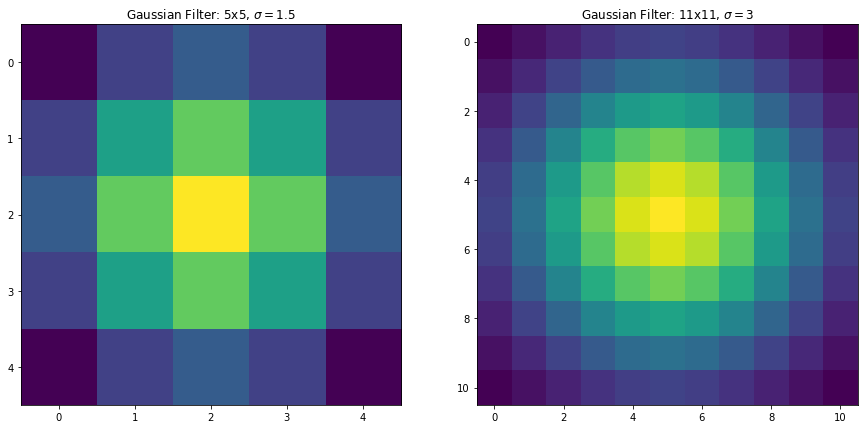

In [22]:
# here we get the gaussian kernel we will use for blurring
gauss2 = gaussian_kernel(11, 3)

# print the X and Y gradients
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
# plt.axis('off')
plt.title(r'Gaussian Filter: 5x5, $\sigma = 1.5$')
plt.imshow(gauss1, cmap = 'viridis')

fig.add_subplot(1, 2, 2)
# plt.axis('off')
plt.title(r'Gaussian Filter: 11x11, $\sigma = 3$')
plt.imshow(gauss2, cmap = 'viridis')
plt.show()

In [23]:
# we carry out the complete canny edge detection and print output
blur2 = np.round(convolve(img, gauss2))
grad2, gx2, gy2, theta2 = grad_matrix(blur2)
grad2 = np.round(grad2)
grad_nms2 = np.round(non_max_suppression(grad2, theta2))
canny2 = np.round(median_threshold(grad_nms2, grad2))

Median Threshold used is: 42.0


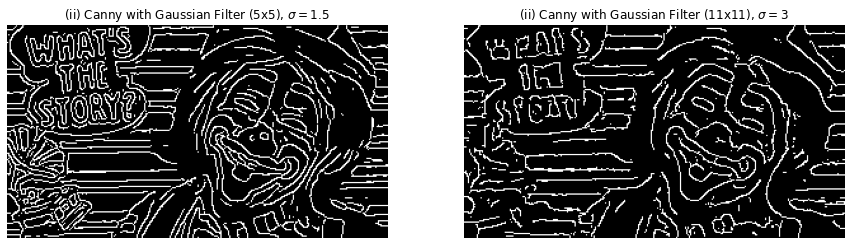

In [24]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title(r'(ii) Canny with Gaussian Filter (5x5), $\sigma = 1.5$')
plt.imshow(canny1, cmap = 'gray')

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title(r'(ii) Canny with Gaussian Filter (11x11), $\sigma = 3$')
plt.imshow(canny2, cmap = 'gray')
plt.savefig("./imgs/canny12.png")
plt.show()